In [9]:
%load_ext autoreload
%autoreload 2

# Imports
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import wandb
from torch.utils.data import DataLoader, Dataset
from omegaconf import OmegaConf
from pathlib import Path
from bachelors_thesis.modeling.siglabv2.siglabv2 import SigLabV2
from bachelors_thesis.modeling.datasets.sigloc_dataset import SigLocDataset
from bachelors_thesis.evaluation import set_level_accuracy, lead_level_accuracy , pretty_code_density_plot
from bachelors_thesis.utils import plot_ecg, confusion_matrix, hungarian_predictions, apply_preprocessors, count_parameters, PRECORDIAL_LEAD_NAMES, LEAD_NAMES
from bachelors_thesis.data.ptbxl_utility import get_ecg_signals_from_file
import seaborn as sns
import pandas as pd
import ast
from torchviz import make_dot
from IPython.display import Image
from collections import Counter
from scipy.ndimage import gaussian_filter1d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
project_path = "nateml-maastricht-university/bachelors-thesis"
#run_id = "4zf4bqsa"
#run_id = "z1tihobt"
#run_id = "38ndk83w"
run_id = "hhn6gbli"
artifact_name = "22_siglabv2_attn_rework"
version = "best"
#artifact_name = "00_siglabv2_test"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
# Load the torch model from wandb
api = wandb.Api()
artifact = api.artifact(f"{project_path}/{artifact_name}:{version}")
artifact_path = artifact.download()

run = api.run(f"{project_path}/{run_id}")
config = dict(run.config)

# Convert config to omegaconf
cfg = OmegaConf.create(config)

# Load the model
checkpoint = torch.load(artifact_path + f"/{artifact_name}.pth", map_location=device)

# Cast the model to the correct type
model = SigLabV2(cfg.model).to(device)
model.load_state_dict(checkpoint)
model.eval()  # Put into evaluation mode

# Count number of parameters
print(f"Loaded model from wandb: {artifact_name}")
count_parameters(model)

wandb:   1 of 1 files downloaded.  


Loaded model from wandb: 22_siglabv2_attn_rework
+----------------------------------------+------------+
|                Modules                 | Parameters |
+----------------------------------------+------------+
|             encoder.alpha              |     1      |
| encoder.cnn_encoder.0.branch1.0.weight |     32     |
|  encoder.cnn_encoder.0.branch1.0.bias  |     32     |
| encoder.cnn_encoder.0.branch1.1.weight |     32     |
|  encoder.cnn_encoder.0.branch1.1.bias  |     32     |
| encoder.cnn_encoder.0.branch2.0.weight |     64     |
|  encoder.cnn_encoder.0.branch2.0.bias  |     64     |
| encoder.cnn_encoder.0.branch2.1.weight |     64     |
|  encoder.cnn_encoder.0.branch2.1.bias  |     64     |
| encoder.cnn_encoder.0.branch2.3.weight |   10240    |
|  encoder.cnn_encoder.0.branch2.3.bias  |     32     |
| encoder.cnn_encoder.0.branch2.4.weight |     32     |
|  encoder.cnn_encoder.0.branch2.4.bias  |     32     |
| encoder.cnn_encoder.0.branch3.0.weight |     64     |

1406023

Loading the data

In [4]:
dataset_path = Path("../../" + cfg.dataset.path)
dataset_path = dataset_path.resolve()

val_data = np.load(dataset_path / "val.npy")

# Apply preprocessors
val_data = apply_preprocessors(val_data,
                               cfg.dataset.sampling_rate,
                               cfg.preprocessor_group.preprocessors)

# Convert to torch tensor
val_data = torch.from_numpy(val_data).float().to(device)
val_data = val_data.permute(0, 2, 1)
print(val_data.shape)

# Create the dataset and dataloader
dataset = SigLocDataset(val_data)
batch_size = 32
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=False)

# Load metadata
meta = pd.read_csv(dataset_path / "meta_val.csv")
meta['scp_codes'] = meta['scp_codes'].apply(lambda x: ast.literal_eval(x))

THRESHOLD = 0.5
def codes_above_threshold(code_dict, thr=THRESHOLD):
    return {code for code, prob in code_dict.items() if prob >= thr}

meta["present_codes"] = meta["scp_codes"].apply(lambda x: codes_above_threshold(x, THRESHOLD))


torch.Size([2183, 6, 1000])


Forward pass through the model

In [5]:
c = cfg.model.num_classes
logits = np.zeros((len(dataset), c, c))
init_logits = np.zeros((len(dataset), c, c))
targets = np.zeros((len(dataset), c))

for idx, (signals, lead_labels) in enumerate(dataloader):
    signals = signals.to(device)
    lead_labels = lead_labels.to(device)

    if idx == 0:
        print(signals.shape)

    # Make predictions
    with torch.no_grad():
        these_logits, these_init_logits = model(signals)
        logits[(idx * batch_size):(idx * batch_size + batch_size)] = these_logits.cpu().numpy()
        init_logits[(idx * batch_size):(idx * batch_size + batch_size)] = these_init_logits.cpu().numpy()
        targets[(idx * batch_size):(idx * batch_size + batch_size)] = lead_labels.cpu().numpy()

print(logits.shape)

torch.Size([32, 6, 1000])
(2183, 6, 6)


Accuracy

In [6]:
#targets = torch.arange(c, device=logits[0].device).expand(logits.shape[0], -1)

if isinstance(logits, np.ndarray):
    logits = torch.from_numpy(logits).float()
if isinstance(init_logits, np.ndarray):
    init_logits = torch.from_numpy(init_logits).float()

probs = nn.functional.softmax(logits, dim=-1)

set_acc = set_level_accuracy(logits=logits.cpu().numpy(), targets=targets)
lead_acc = lead_level_accuracy(logits=logits.cpu().numpy(), targets=targets)
print(f"Set level accuracy: {set_acc:.4f}")
print(f"Lead level accuracy: {lead_acc:.4f}")

Set level accuracy: 0.9350
Lead level accuracy: 0.9753


In [8]:
set_acc = set_level_accuracy(logits=init_logits.cpu().numpy(), targets=targets)
lead_acc = lead_level_accuracy(logits=init_logits.cpu().numpy(), targets=targets)
print(f"Set level accuracy: {set_acc:.4f}")
print(f"Lead level accuracy: {lead_acc:.4f}")

Set level accuracy: 0.6399
Lead level accuracy: 0.9101


In [9]:
hungarian_preds = hungarian_predictions(logits.cpu().numpy())
hungarian_set_acc = set_level_accuracy(predictions=hungarian_preds, targets=targets)
hungarian_lead_acc = lead_level_accuracy(predictions=hungarian_preds, targets=targets)
print(f"Hungarian set level accuracy: {hungarian_set_acc:.4f}")
print(f"Hungarian lead level accuracy: {hungarian_lead_acc:.4f}")

Hungarian set level accuracy: 0.9455
Hungarian lead level accuracy: 0.9760


In [10]:
hungarian_preds.shape

(2183, 6)

In [11]:
precordial_hungarian_preds = hungarian_preds[mask].reshape(-1, 6)
precordial_hung_set_acc = set_level_accuracy(predictions=precordial_hungarian_preds, targets=vals)
precordial_hung_lead_acc = lead_level_accuracy(predictions=precordial_hungarian_preds, targets=vals)
print(f"Precordial set level accuracy: {precordial_hung_set_acc:.4f}")
print(f"Precordial lead level accuracy: {precordial_hung_lead_acc:.4f}")

Precordial set level accuracy: 0.9455
Precordial lead level accuracy: 0.9760


# Find incorrect classifications

In [12]:
predictions = torch.argmax(logits, dim=-1).cpu().numpy()
mistake_mask = predictions != targets
mistake_counts = mistake_mask.sum(axis=1)
wrong = []
for i in range(1, 7):
    wrong.append(np.where(mistake_counts >= i)[0])

print(wrong[0])
print(len(wrong[0]))

[  23   35   36   52   57   70   75   76   78   92  100  101  114  166
  167  185  198  214  215  224  226  228  243  252  281  304  315  325
  367  380  387  394  402  419  459  464  468  470  471  476  480  483
  502  524  538  567  569  578  669  671  673  683  689  717  749  754
  766  797  801  848  854  859  874  881  883  895  927  936  948  955
  956  961  966  986  994  999 1000 1004 1058 1065 1067 1077 1096 1186
 1206 1215 1218 1220 1222 1240 1243 1250 1260 1266 1293 1296 1299 1306
 1309 1320 1339 1379 1395 1407 1424 1453 1459 1468 1486 1489 1510 1512
 1546 1547 1550 1595 1614 1632 1647 1677 1689 1709 1754 1771 1789 1808
 1862 1866 1876 1901 1911 1927 1963 2004 2005 2011 2027 2041 2043 2100
 2150 2176]
142


slag med avvikande impulsutbredning supraventrikulÄr(a) extrasystoli(er) sinusrytm extrem vÄnster el-axel avvikande qrs(t) fÖrlopp    anterior myokardskada    inferior myokardskada


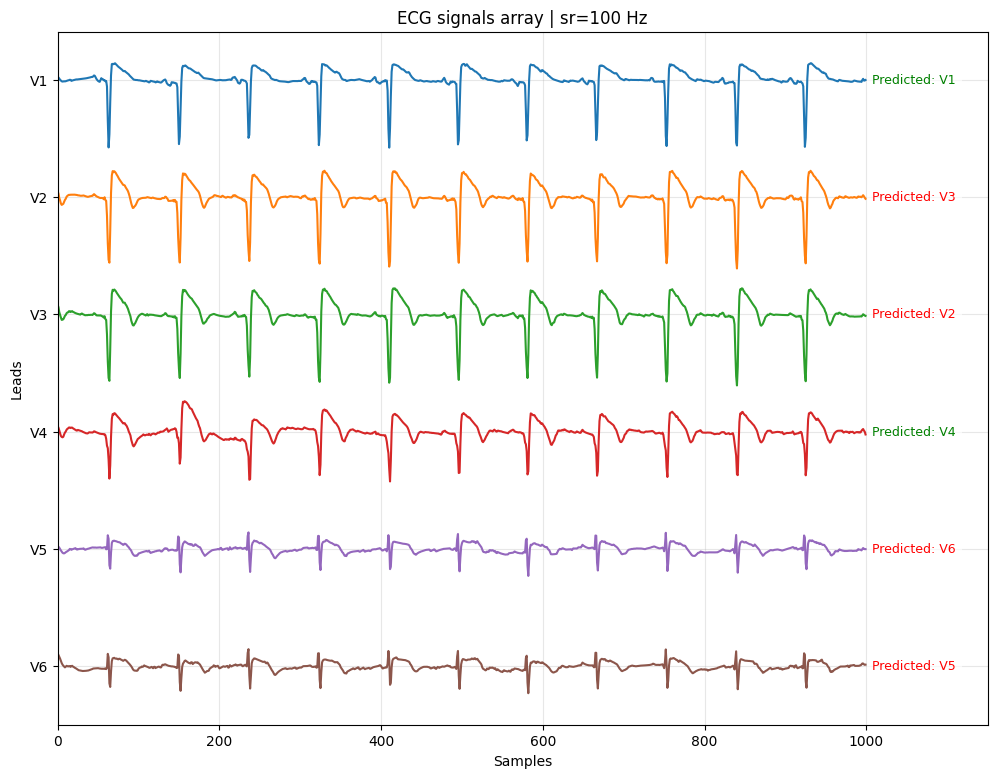

In [15]:
idx = wrong[0][1]
#idx = 0
signals = val_data[idx].cpu().numpy()
str_predictions = [PRECORDIAL_LEAD_NAMES[p] for p in predictions[idx]]
plot_ecg(signals, sampling_rate=cfg.dataset.sampling_rate, predictions=str_predictions)
print(meta.iloc[idx].report)

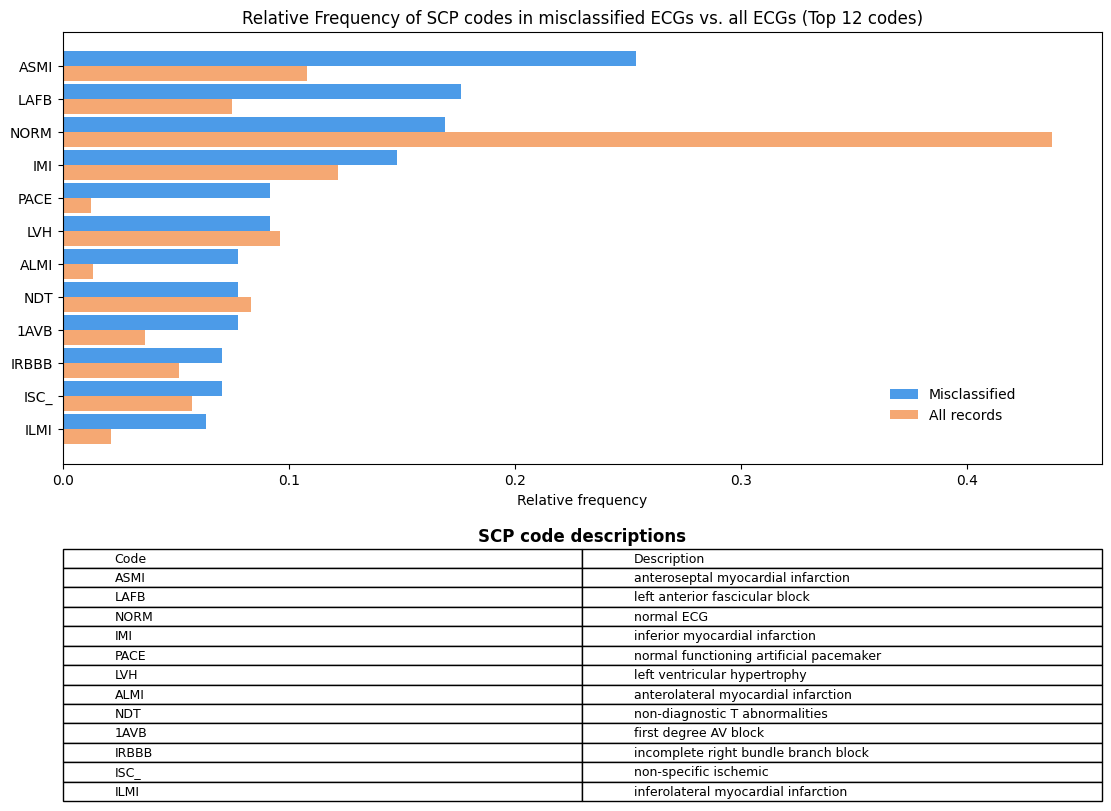

In [16]:
distribution = Counter(code
                       for codes in meta["present_codes"]
                       for code in codes)

outlier_distribution = Counter(code
                                for codes in meta.iloc[wrong[0]]["present_codes"]
                                for code in codes)

pretty_code_density_plot(
    distribution,
    outlier_distribution,
    n = 12,
    n_misclassified=len(wrong[0]),
    n_total=len(meta),
    relative=True,
    scp_statement_csv='../../data/raw/ptb-xl/scp_statements.csv',
)

In [17]:
# Calculate accuracy on pacemaker samples
pacemaker_idx = np.where(meta["present_codes"].apply(lambda x: "PACE" in x))[0]
print(len(pacemaker_idx))

pacemaker_acc = set_level_accuracy(predictions=predictions[pacemaker_idx])
pacemaker_acc

27


np.float64(0.5185185185185185)

In [18]:
int(np.max(targets) + 1)

6

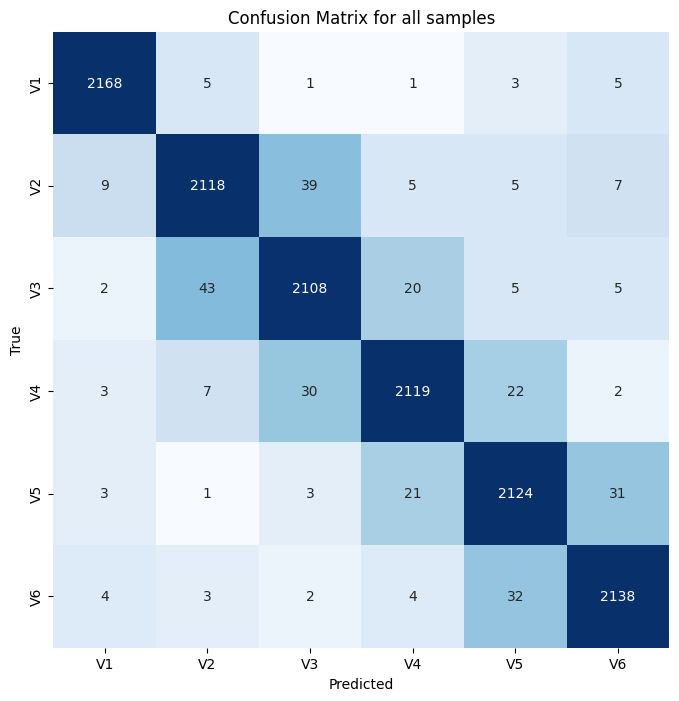

In [19]:
# Confusion matrix

cm = confusion_matrix(predictions, targets)
cm_log = np.log(cm + 1)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_log, annot=cm, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=PRECORDIAL_LEAD_NAMES, yticklabels=PRECORDIAL_LEAD_NAMES)
plt.title("Confusion Matrix for all samples")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()    


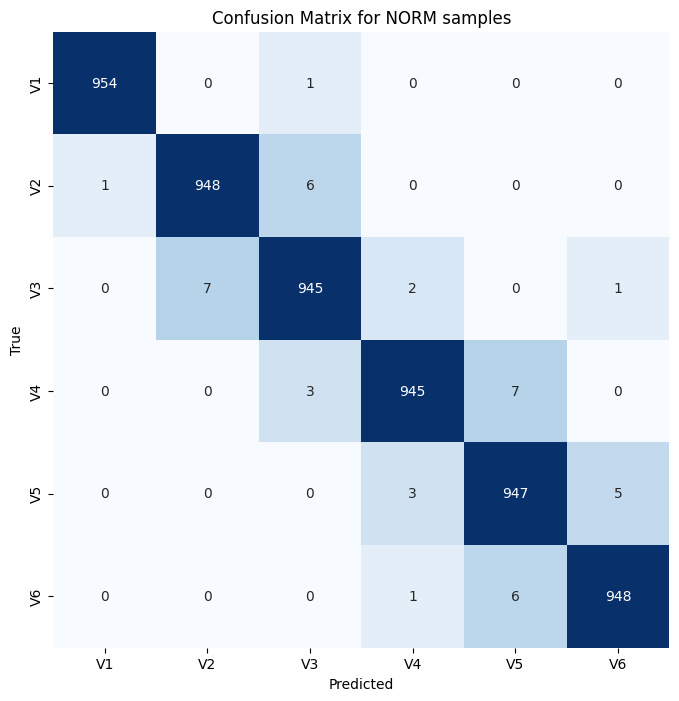

In [20]:
# Confusion matrix for NORM samples
norm_idx = np.where(meta["present_codes"].apply(lambda x: "NORM" in x))[0]

cm = confusion_matrix(predictions[norm_idx], targets[norm_idx])
cm_log = np.log(cm + 1)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_log, annot=cm, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=PRECORDIAL_LEAD_NAMES, yticklabels=PRECORDIAL_LEAD_NAMES)
plt.title("Confusion Matrix for NORM samples")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()    

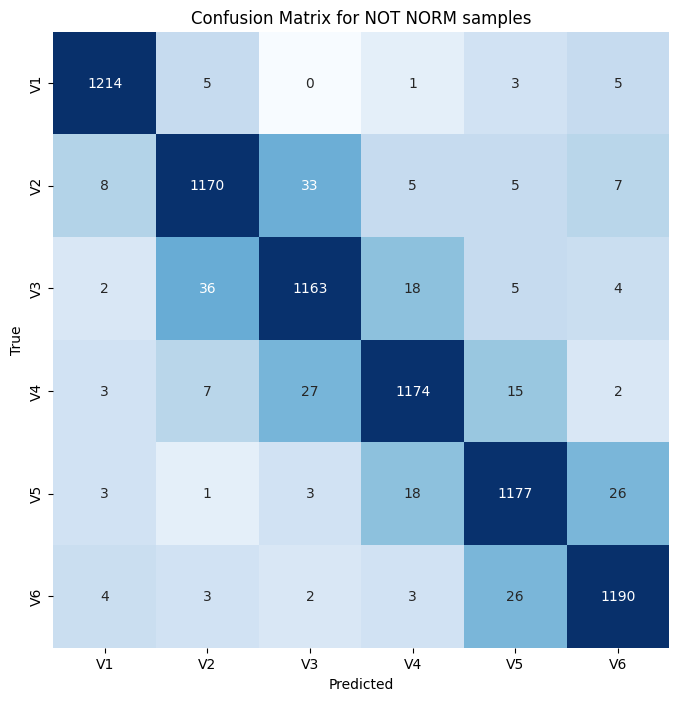

In [21]:
not_norm_idx = np.where(meta["present_codes"].apply(lambda x: "NORM" not in x))[0]

cm = confusion_matrix(predictions[not_norm_idx], targets[not_norm_idx])
cm_log = np.log(cm + 1)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_log, annot=cm, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=PRECORDIAL_LEAD_NAMES, yticklabels=PRECORDIAL_LEAD_NAMES)
plt.title("Confusion Matrix for NOT NORM samples")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()    

Normal:  955
Mycardial Infarction:  540
ST/T change:  528
Conduction disturbance:  495
Hypertrophy:  268


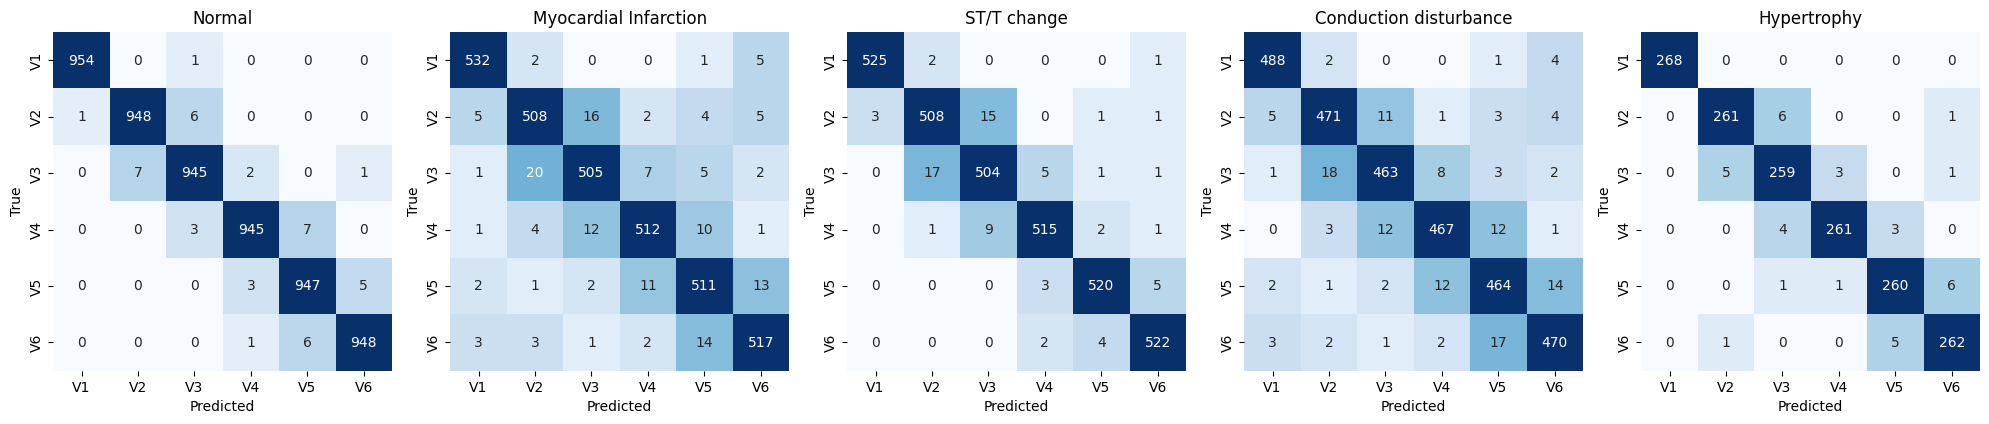

In [22]:
# Normal samples
norm_idx = np.where(meta["diagnostic_superclass"].apply(lambda x: "NORM" in x))[0]
print("Normal: ", len(norm_idx))

# Mycardial infarction samples
mi_idx = np.where(meta["diagnostic_superclass"].apply(lambda x: "MI" in x))[0]
print("Mycardial Infarction: ", len(mi_idx))

# ST/T change
sttc_idx = np.where(meta["diagnostic_superclass"].apply(lambda x: "STTC" in x))[0]
print("ST/T change: ", len(sttc_idx))

# Conduction disturbance
cd_idx = np.where(meta["diagnostic_superclass"].apply(lambda x: "CD" in x))[0]
print("Conduction disturbance: ", len(cd_idx))

# Hypertrophy
hypertrophy_idx = np.where(meta["diagnostic_superclass"].apply(lambda x: "HYP" in x))[0]
print("Hypertrophy: ", len(hypertrophy_idx))

# Calculate confusion matrices for each subset
cm_norm = confusion_matrix(predictions[norm_idx], targets[norm_idx])
cm_mi = confusion_matrix(predictions[mi_idx], targets[mi_idx])
cm_sttc = confusion_matrix(predictions[sttc_idx], targets[sttc_idx])
cm_cd = confusion_matrix(predictions[cd_idx], targets[cd_idx])
cm_hypertrophy = confusion_matrix(predictions[hypertrophy_idx], targets[hypertrophy_idx])

# Log-transform the confusion matrices for better visualization
cm_norm_log = np.log(cm_norm + 1)
cm_mi_log = np.log(cm_mi + 1)
cm_sttc_log = np.log(cm_sttc + 1)
cm_cd_log = np.log(cm_cd + 1)
cm_hypertrophy_log = np.log(cm_hypertrophy + 1)

# Visualize the confusion matrices
plt.figure(figsize=(20, 8))
plt.subplot(1, 5, 1)
sns.heatmap(cm_norm_log, annot=cm_norm, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=PRECORDIAL_LEAD_NAMES, yticklabels=PRECORDIAL_LEAD_NAMES)
plt.title("Normal")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.subplot(1, 5, 2)
sns.heatmap(cm_mi_log, annot=cm_mi, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=PRECORDIAL_LEAD_NAMES, yticklabels=PRECORDIAL_LEAD_NAMES)
plt.title("Myocardial Infarction")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.subplot(1, 5, 3)
sns.heatmap(cm_sttc_log, annot=cm_sttc, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=PRECORDIAL_LEAD_NAMES, yticklabels=PRECORDIAL_LEAD_NAMES)
plt.title("ST/T change")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.subplot(1, 5, 4)
sns.heatmap(cm_cd_log, annot=cm_cd, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=PRECORDIAL_LEAD_NAMES, yticklabels=PRECORDIAL_LEAD_NAMES)
plt.title("Conduction disturbance")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.subplot(1, 5, 5)
sns.heatmap(cm_hypertrophy_log, annot=cm_hypertrophy, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=PRECORDIAL_LEAD_NAMES, yticklabels=PRECORDIAL_LEAD_NAMES)
plt.title("Hypertrophy")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [77]:
# Calculate acc on all diagnostic superclasses
acc_norm = cm_norm.diagonal().sum() / cm_norm.sum()
acc_mi = cm_mi.diagonal().sum() / cm_mi.sum()
acc_sttc = cm_sttc.diagonal().sum() / cm_sttc.sum()
acc_cd = cm_cd.diagonal().sum() / cm_cd.sum()
acc_hypertrophy = cm_hypertrophy.diagonal().sum() / cm_hypertrophy.sum()
print(f"Normal: {acc_norm:.4f}")
print(f"Myocardial Infarction: {acc_mi:.4f}")
print(f"ST/T change: {acc_sttc:.4f}")
print(f"Conduction disturbance: {acc_cd:.4f}")
print(f"Hypertrophy: {acc_hypertrophy:.4f}")

Normal: 0.9925
Myocardial Infarction: 0.9522
ST/T change: 0.9766
Conduction disturbance: 0.9505
Hypertrophy: 0.9770


Interpreting the model

In [23]:
sample = wrong[-1][0]
sample = 0
time_window = (0, 1000)

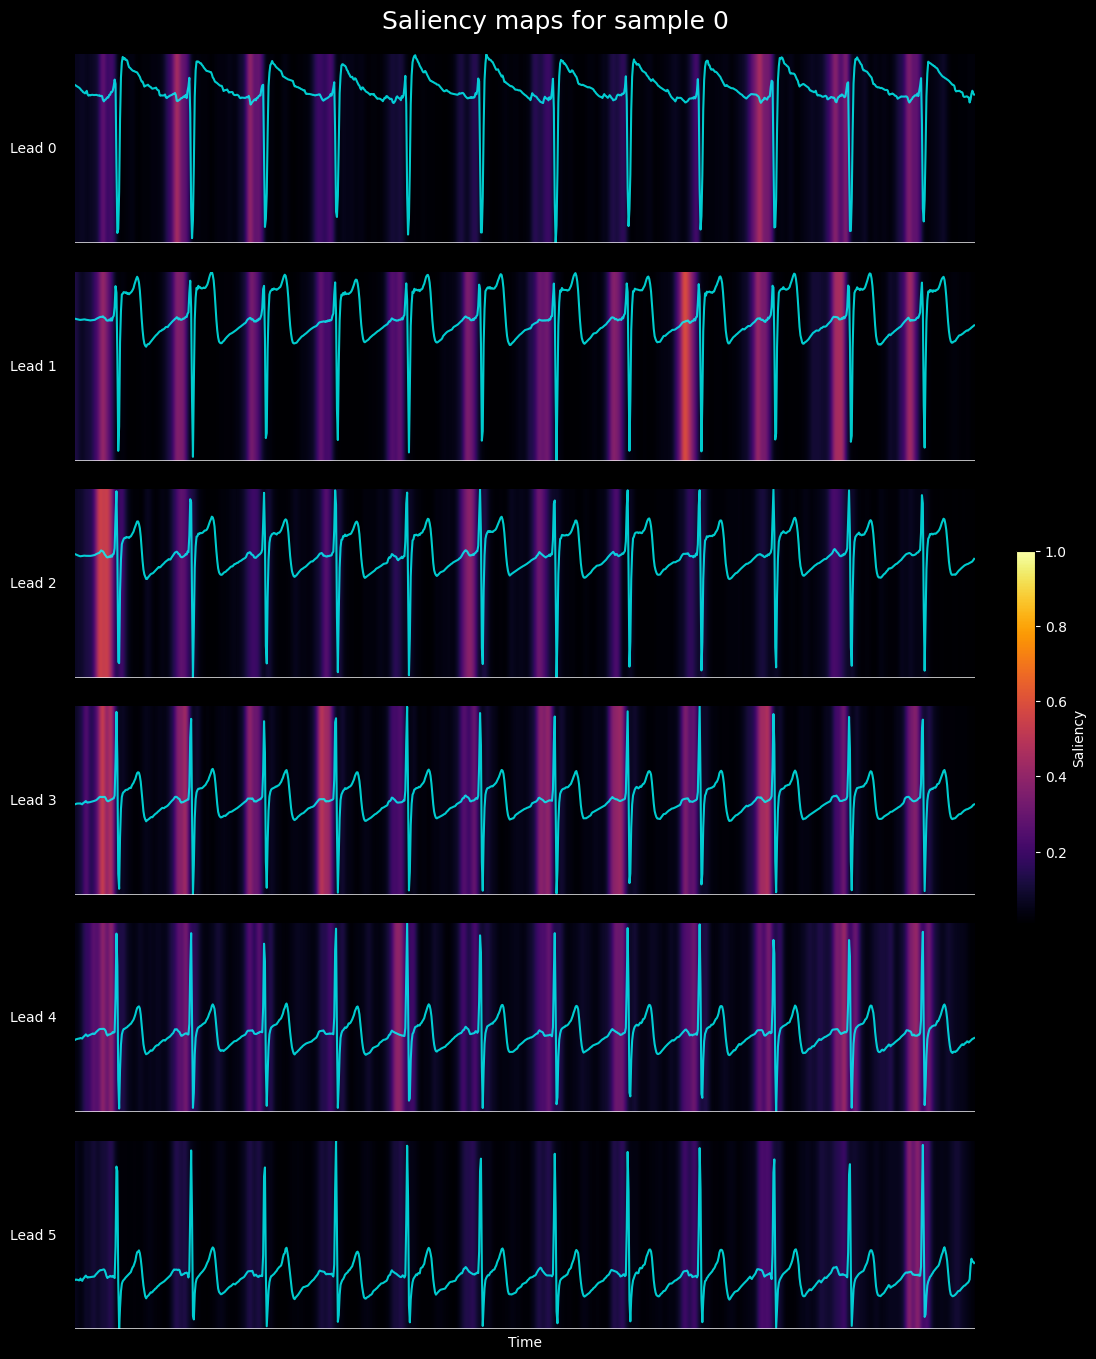

In [24]:
lead_indices = [0, 1, 2, 3, 4, 5]  # define the leads you want to visualize

x = val_data[sample].unsqueeze(0)  # shape [1, L, T]
x.requires_grad = True
x.to(device)

# put the model in train mode to get gradients
model.train()

# Get output and select the classification head output
output = model(x)[0][0]  # [num_leads, num_classes]

# Create subplots
num_leads = len(lead_indices)
fig, axes = plt.subplots(num_leads, 1, figsize=(12, 2.5 * num_leads), sharex=True,
                         gridspec_kw={'hspace': 0.15})

for i, lead in enumerate(lead_indices):
    lead_output = output[lead]
    target_idx = lead_output.argmax()
    target = lead_output[target_idx]

    model.zero_grad()
    x.grad = None
    target.backward(retain_graph=True)

    saliency = x.grad.data.abs()[0, lead].cpu().numpy()
    saliency = saliency / saliency.max()
    saliency = saliency[time_window[0]:time_window[1]]
    saliency_smooth = gaussian_filter1d(saliency, sigma=3)
    saliency_2d = saliency_smooth[np.newaxis, :]

    ecg = x[0, lead].cpu().detach().numpy()
    ecg = ecg[time_window[0]:time_window[1]]
    ecg_scaled = (ecg - ecg.min()) / (ecg.max() - ecg.min())

    ax = axes[i] if num_leads > 1 else axes
    im = ax.imshow(saliency_2d,
                   cmap='inferno',
                   aspect='auto',
                   extent=[0, len(ecg), 0, 1],
                   norm=plt.Normalize(vmin=0.01, vmax=saliency.max()))

    ax.plot(np.arange(len(ecg)), ecg_scaled, color='cyan', linewidth=1.5, linestyle='-', alpha=0.8)

    # Minimal labeling
    ax.set_yticks([])
    ax.set_ylabel(f"Lead {lead}", color='white', rotation=0, labelpad=30, fontsize=10, va='center')
    ax.set_facecolor('black')
    ax.tick_params(colors='white')
    ax.axhline(y=0, color='white', linewidth=2, alpha=0.8)

    # Clean borders
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Hide x-ticks on all but last subplot
    if i < num_leads - 1:
        ax.set_xticks([])
    else:
        ax.set_xlabel('Time', color='white')

# Add a single colorbar to the side
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label('Saliency', color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(cbar.ax.get_yticklabels(), color='white')

# Title for the whole figure
fig.suptitle(f'Saliency maps for sample {sample}', color='white', fontsize=18)
fig.patch.set_facecolor('black')

#plt.tight_layout(rect=[0, 0, 0.97, 0.90])
plt.subplots_adjust(left=0.1, right=0.85, top=0.95, bottom=0.1)
plt.show()

## Visualising the iterative classification refinement

In [35]:
logits_numpy = logits.cpu().numpy()
mismatches = np.where(logits_numpy.argmax(-1) != init_logits.cpu().numpy().argmax(-1))[0]

In [36]:
idx = mismatches[0]
print(init_logits[idx].argmax(-1))
print(logits[idx].argmax(-1))

tensor([1, 1, 2, 3, 4, 5])
tensor([0, 1, 2, 3, 4, 5])


In [37]:
# ----‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑
# storage for intermediates
# ----‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑
logit_trace = {}          # {layer_name: tensor[B, C]}
def make_hook(name):
    def _hook(module, inputs, output):
        # detach → no autograd, move to CPU for easy inspection
        logit_trace[name] = output.detach().cpu()
    return _hook

# ----‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑
# attach to the initial head
# ----‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑
model.init_head.register_forward_hook(make_hook("init_head"))

# ----‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑
# attach to every AttnBeliefUpdate.head in belief_layers
# ----‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑
for i, bl in enumerate(model.belief_layers):
    bl.head.register_forward_hook(make_hook(f"belief_{i+1}"))

In [38]:
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=False)
model.eval()                 # or model.train() if you want dropout etc.
with torch.no_grad():        # no need for gradients when just observing
    x = val_data[mismatches[0]].unsqueeze(0).to(device)  # one batch is enough
    _ = model(x)             # forward pass populates logit_trace

In [39]:
for name, logits in logit_trace.items():
    print(f"{name:10s}  {logits.shape}  "
          f"{logits.argmax(-1)[0]}")

init_head   torch.Size([1, 6, 6])  tensor([1, 1, 2, 3, 4, 5])
belief_1    torch.Size([1, 6, 6])  tensor([5, 5, 0, 0, 0, 1])
belief_2    torch.Size([1, 6, 6])  tensor([0, 2, 1, 4, 4, 0])
belief_3    torch.Size([1, 6, 6])  tensor([0, 1, 2, 3, 4, 5])


In [40]:
from sklearn.decomposition import PCA

def extract_iter_features(model, signals):
    model.eval()

    with torch.no_grad():
        # 1) encode and first SAB
        features = model.encoder(signals)
        features = model.sab(features)
        feat_list = [features.detach().cpu()]

        # 2) initial logits (we ignore)
        logits = model.init_head(features)

        # 3) each belief update
        new_logits = logits.clone()
        for layer in model.belief_layers:
            feature, new_logits = layer(new_logits, features)
            feat_list.append(feature.detach().cpu())

    return feat_list, logits.detach().cpu(), new_logits.detach().cpu()

def plot_iter_features(features, batch_idx=0, title=None):
    num_iters = len(features)
    pca = PCA(n_components=2)

    fix, axs = plt.subplots(1, num_iters, figsize=(num_iters * 4, 4))

    if num_iters == 1:
        axs = [axs]
        
    for i, feat in enumerate(features):
        X = feat[batch_idx]
        X2 = pca.fit_transform(X.numpy())

        ax = axs[i]
        ax.scatter(X2[:, 0], X2[:, 1], s=50)

        for j, (x, y) in enumerate(X2):
            ax.text(x, y, str(j), fontsize=9, ha='center', va='center')

        ax.set_title(f"Iteration {i+1}")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()


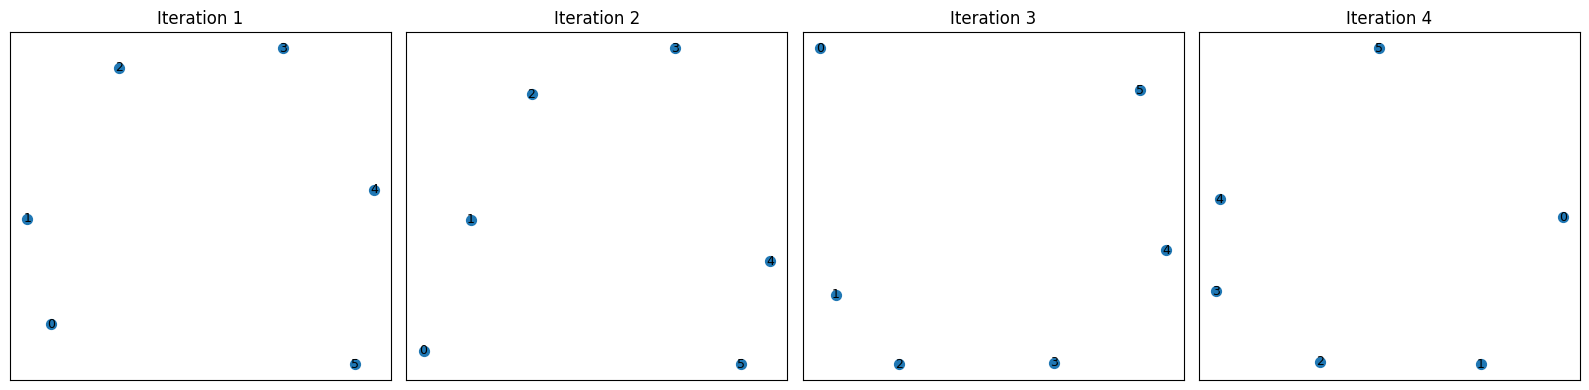

In [42]:
dataloader = DataLoader(dataset,
                        batch_size=30,
                        shuffle=False)
signals, _ = next(iter(dataloader))
features = extract_iter_features(model, signals)[0]
plot_iter_features(features, batch_idx=8, title="Features for first sample")

## PCA

In [43]:
model

SigLabV2(
  (encoder): CNNGRUEncoder(
    (cnn_encoder): Sequential(
      (0): InceptionBlock(
        (branch1): Sequential(
          (0): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (branch2): Sequential(
          (0): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(64, 32, kernel_size=(5,), stride=(1,), padding=(2,))
          (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
        (branch3): Sequential(
          (0): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(64, 32, kernel_size=(11,), stride=(1,), paddin

In [44]:
from sklearn.decomposition import PCA
from collections import defaultdict
from tqdm import tqdm

# ▸ 1. pick the layer you want to inspect
#     (example: model.encoder.cnn_post_layers[0] – an AdaptiveAvgPool1d)
# layer_to_hook = model.encoder.cnn_post_layers[2]   # <-- customise here
layer_to_hook = model.belief_layers[-1].sab   # <-- customise here

feature_store = []

def hook(module, inp, out):
    """
    Capture the tensor you care about.
    Expecting shape (B*N, D).
    """
    feature_store.append(out.detach().cpu())

hook_handle = layer_to_hook.register_forward_hook(hook)

# ▸ 2. run the model on a few batches and collect features
lead_labels  = []        # one lead label per feature vector
lead_vectors = []        # flattened feature vectors

dataloader = DataLoader(dataset,
                        batch_size=32,  
                        shuffle=False) 

model.eval()
#n_batches = 50           # feel free to increase
with torch.no_grad():
    for i, batch in enumerate(tqdm(dataloader)):
        #if i >= n_batches: break
        x, _ = batch         # or whatever your DataLoader yields
        x = x.to(device)     # shape (B, C, 1000)
        _, *_ = model(x)         # populates feature_store

        feat   = feature_store.pop()  # (B*N, D)
        # Reshape to (B, N, D) if needed
        #feat   = feat.reshape(x.size(0), x.size(1), -1)  # (B, N, D)

        B = feat.shape[0]
        for b in range(B):  # Iterate over batch
            for lead in range(x.size(1)):            # Iterate over leads
                lead_vectors.append(feat[b, lead].numpy())         # Append the feature vector
                lead_labels .append(lead)            # 0…5

hook_handle.remove()

lead_vectors = np.vstack(lead_vectors)   # (samples, C_feat)
lead_labels  = np.array(lead_labels)     # (samples,)

100%|██████████| 69/69 [00:02<00:00, 26.55it/s]


In [45]:
lead_vectors.shape, lead_labels.shape

((13098, 128), (13098,))

In [46]:
# ▸ 3. PCA → 2-D
pca  = PCA(n_components=2, random_state=0)
proj = pca.fit_transform(lead_vectors)   # (samples, 2)

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import interp1d                    # for smooth colour wheel

def pretty_pca_plot(xy, labels, title="Latent-space bouquet",
                    point_size=18, alpha_back=0.10, alpha_front=0.75,
                    pad=0.1):
    """
    xy       – (N,2) array of points
    labels   – (N,) array with integer lead IDs 0…5
    """
    # ------------------------------------------------------------
    # Set up a dark, minimal aesthetic
    # ------------------------------------------------------------
    mpl.rcParams.update({
        "figure.facecolor":   "#111216",
        "axes.facecolor":     "#111216",
        "axes.edgecolor":     "#888888",
        "axes.labelcolor":    "#CCCCCC",
        "xtick.color":        "#888888",
        "ytick.color":        "#888888",
        "axes.grid":          False,
        "font.size":          12,
    })
    plt.style.use("dark_background")

    # ------------------------------------------------------------
    # Build a smooth 6-colour circular palette
    # ------------------------------------------------------------
    base = np.array([[0.24,0.63,1.0],    # blue
                     [0.19,0.83,0.94],   # teal
                     [0.27,0.89,0.52],   # green
                     [1.00,0.78,0.28],   # orange
                     [1.00,0.48,0.32],   # coral
                     [0.89,0.33,0.65]])  # magenta
    # tile + interpolate so colours wrap around smoothly
    base = np.vstack([base, base[0,None]])
    wheel = interp1d(np.linspace(0,6,7), base, axis=0)(np.arange(6))

    # ------------------------------------------------------------
    # Two-layer scatter for subtle glow
    # ------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(7,6), dpi=400)

    for k in range(6):
        idx = labels == k
        # back layer – large, low-alpha halo
        ax.scatter(xy[idx,0], xy[idx,1], s=point_size*2,
                   color=wheel[k], alpha=alpha_back, linewidths=0)
        # front layer – crisp centre
        ax.scatter(xy[idx,0], xy[idx,1], s=point_size,
                   color=wheel[k], alpha=alpha_front, linewidths=0)

    # ------------------------------------------------------------
    # Finishing touches
    # ------------------------------------------------------------
    ax.set_title(title, color="#E0E0E0", pad=12, weight="semibold")
    ax.set_xlabel("PC 1"); ax.set_ylabel("PC 2")
    ax.set_aspect("equal", adjustable="datalim")

    ax.set_xlim(xy[:,0].min()-0.5, xy[:,0].max()+0.5)
    ax.set_ylim(xy[:,1].min()-0.5, xy[:,1].max()+0.5)

    # dark legend
    handles = [mpl.lines.Line2D([], [], color=wheel[k], marker="o", linestyle="",
                                markersize=6) for k in range(6)]
    ax.legend(handles,
              [f"Lead {k+1}" for k in range(6)],
              frameon=False, loc="lower right", labelcolor="#DDDDDD",
              fontsize=8, markerscale=0.8, handlelength=1.2)

    xmin, xmax = xy[:,0].min(), xy[:,0].max()
    ymin, ymax = xy[:,1].min(), xy[:,1].max()

    xrange = xmax - xmin
    yrange = ymax - ymin

    ax.set_xlim(xmin - pad * xrange, xmax + pad * xrange)
    ax.set_ylim(ymin - pad * yrange, ymax + pad * yrange)

    plt.tight_layout()
    plt.show()


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


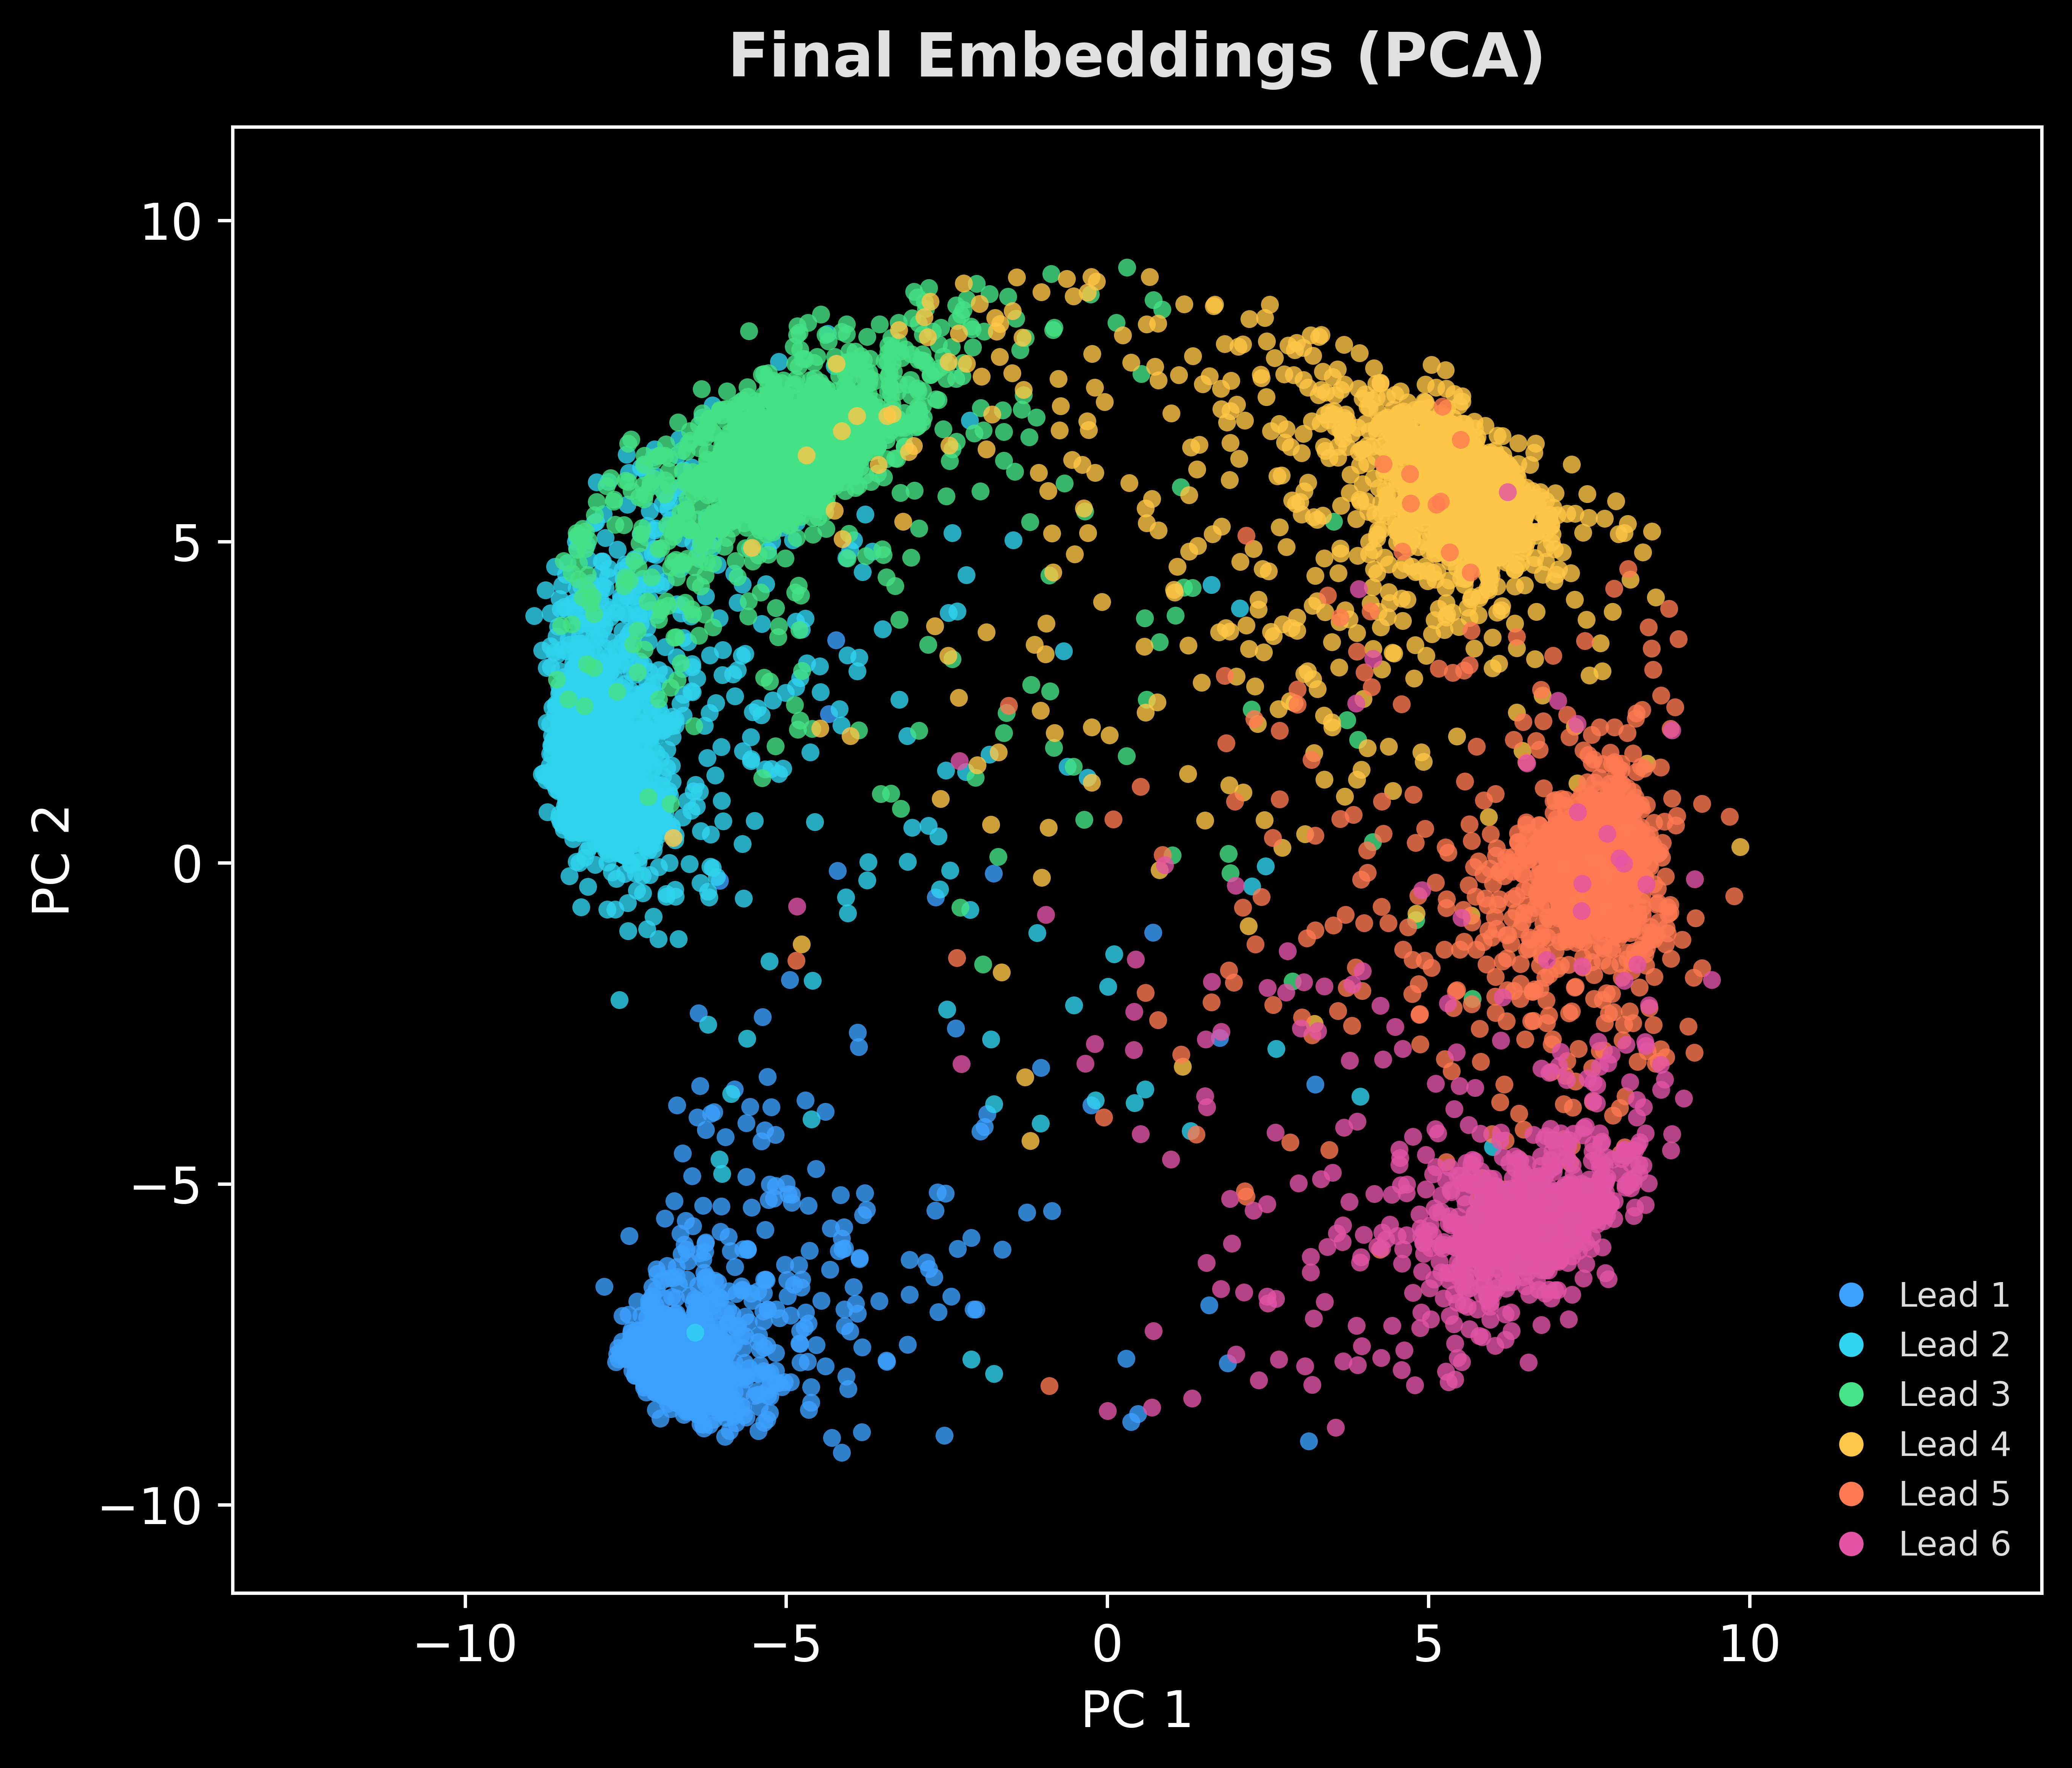

In [49]:
%config InlineBackend.figure_format = 'retina'  # for high-res plots
plt.ion()
pretty_pca_plot(proj, lead_labels, title="Final Embeddings (PCA)", pad=0.25,
                alpha_front=0.8, alpha_back=0)

# Visualising Activations

In [52]:
# ----‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑
# storage for intermediates
# ----‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑
activation_trace = {}        # {layer_name: tensor[B, T]}
def make_hook(name):
    def _hook(module, inputs, output):
        # detach → no autograd, move to CPU for easy inspection
        activation_trace[name] = output.detach().cpu()
    return _hook

def gru_hook(module, inputs, output):
    out_seq, h_n = output
    activation_trace["gru"] = out_seq.detach().cpu()

# ----‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑
# attach to the post-gru activations
# ----‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑
model.encoder.gru.register_forward_hook(gru_hook)

# ----‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑
# attach to every InceptionBlock
# ----‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑‑
hook_handles = []
hook_handles.append(model.encoder.cnn_encoder[4].branch1.register_forward_hook(make_hook("branch1")))
hook_handles.append(model.encoder.cnn_encoder[4].branch2.register_forward_hook(make_hook("branch2")))
hook_handles.append(model.encoder.cnn_encoder[4].branch3.register_forward_hook(make_hook("branch3")))
hook_handles.append(model.encoder.cnn_encoder[4].branch4.register_forward_hook(make_hook("branch4")))


In [53]:
np.where(meta["diagnostic_superclass"].apply(lambda x: "NORM" in x))[0]

array([   1,   12,   15,   16,   17,   18,   19,   20,   24,   28,   32,
         37,   39,   40,   41,   42,   44,   46,   47,   50,   54,   56,
         58,   59,   60,   61,   62,   63,   66,   67,   68,   70,   72,
         73,   74,   76,   85,   89,   90,   93,   96,   97,  103,  104,
        105,  106,  107,  108,  113,  115,  116,  119,  120,  121,  123,
        124,  125,  126,  127,  128,  129,  131,  132,  133,  135,  136,
        137,  141,  143,  145,  147,  148,  150,  152,  153,  156,  159,
        161,  162,  163,  165,  167,  174,  175,  176,  184,  186,  188,
        191,  193,  194,  197,  199,  200,  201,  202,  203,  204,  207,
        209,  212,  213,  218,  220,  221,  222,  223,  224,  229,  232,
        233,  245,  248,  249,  251,  254,  256,  259,  261,  262,  264,
        266,  268,  269,  270,  271,  273,  275,  276,  277,  279,  280,
        281,  285,  287,  288,  289,  290,  291,  292,  293,  298,  299,
        300,  301,  302,  305,  306,  308,  313,  3

In [54]:
#sample = wrong[-1][0]
sample = 12
model.eval()                 # or model.train() if you want dropout etc.
with torch.no_grad():        # no need for gradients when just observing
    x = val_data[sample].unsqueeze(0).to(device)
    _ = model(x)             # forward pass populates logit_trace

# Unregister the hooks
for handle in hook_handles:
    handle.remove()

In [56]:
lead = 1
gru_delta = activation_trace['gru'][lead][1:] - activation_trace['gru'][lead][:-1]
gru_curve = gru_delta.abs().sum(-1).cpu().numpy()
branch1_curve = activation_trace['branch1'][lead].sum(0).cpu().numpy()
branch2_curve = activation_trace['branch2'][lead].sum(0).cpu().numpy()
branch3_curve = activation_trace['branch3'][lead].sum(0).cpu().numpy()
branch5_curve = activation_trace['branch4'][lead].sum(0).cpu().numpy()

In [57]:
# Unpool to get activations to match the original input shape
T = 1000
L_c = branch1_curve.shape[0]
T_g = gru_curve.shape[0]
x_inp = np.linspace(0, 1, T)
branch1_curve = np.interp(x_inp, np.linspace(0, 1, L_c), branch1_curve)
branch2_curve = np.interp(x_inp, np.linspace(0, 1, L_c), branch2_curve)
branch3_curve = np.interp(x_inp, np.linspace(0, 1, L_c), branch3_curve)
branch5_curve = np.interp(x_inp, np.linspace(0, 1, L_c), branch5_curve)
gru_curve = np.interp(x_inp, np.linspace(0, 1, T_g), gru_curve)

branch1_curve.shape, branch2_curve.shape, branch3_curve.shape, branch5_curve.shape, gru_curve.shape

((1000,), (1000,), (1000,), (1000,), (1000,))

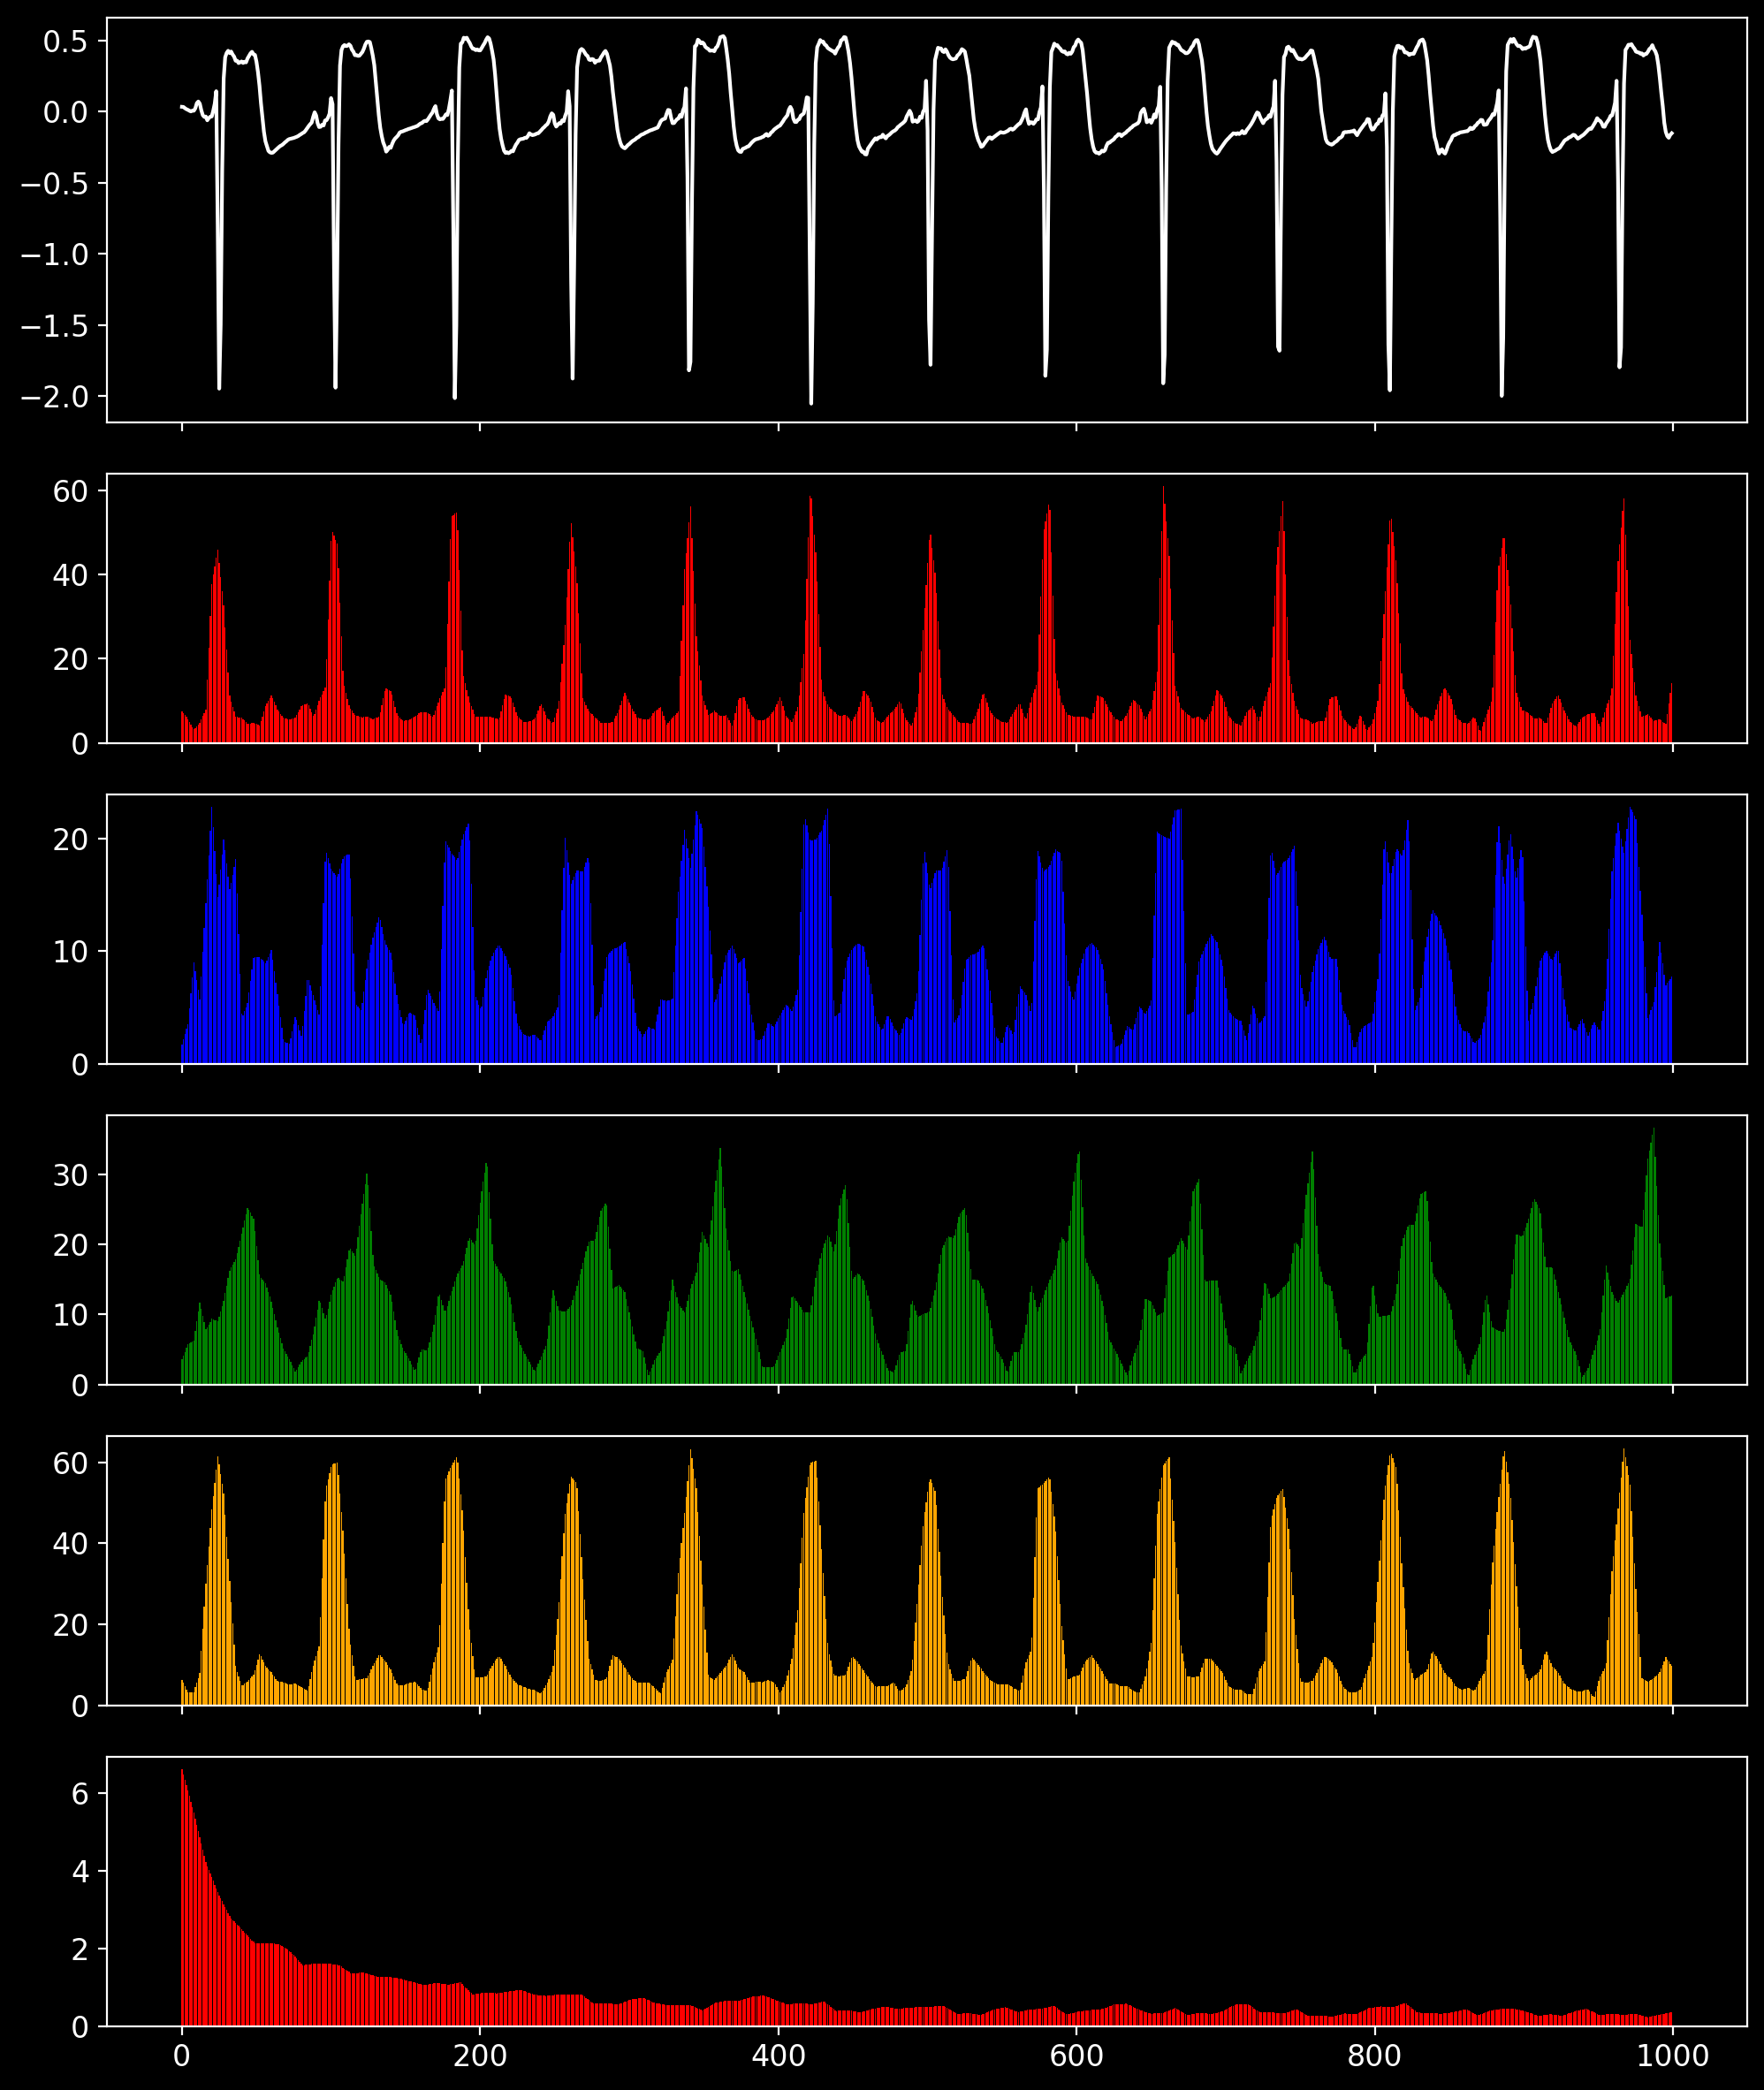

In [59]:
# Visualise the activations of the gru_last layer
fig, axs = plt.subplots(6, 1, figsize=(10, 12), sharex=True, gridspec_kw={'height_ratios':[3,2,2,2,2,2]})
axs[0].plot(val_data[sample][lead].cpu().numpy(), color='white', label='ECG')
axs[1].bar(np.arange(T), branch1_curve, color='red', label='Branch 1')
axs[2].bar(np.arange(T), branch2_curve, color='blue', label='Branch 2')
axs[3].bar(np.arange(T), branch3_curve, color='green', label='Branch 3')
axs[4].bar(np.arange(T), branch5_curve, color='orange', label='Branch 5')
axs[5].bar(np.arange(T), gru_curve, color='red', label='GRU')

plt.tight_layout()
plt.show()

shape: torch.Size([125, 128])


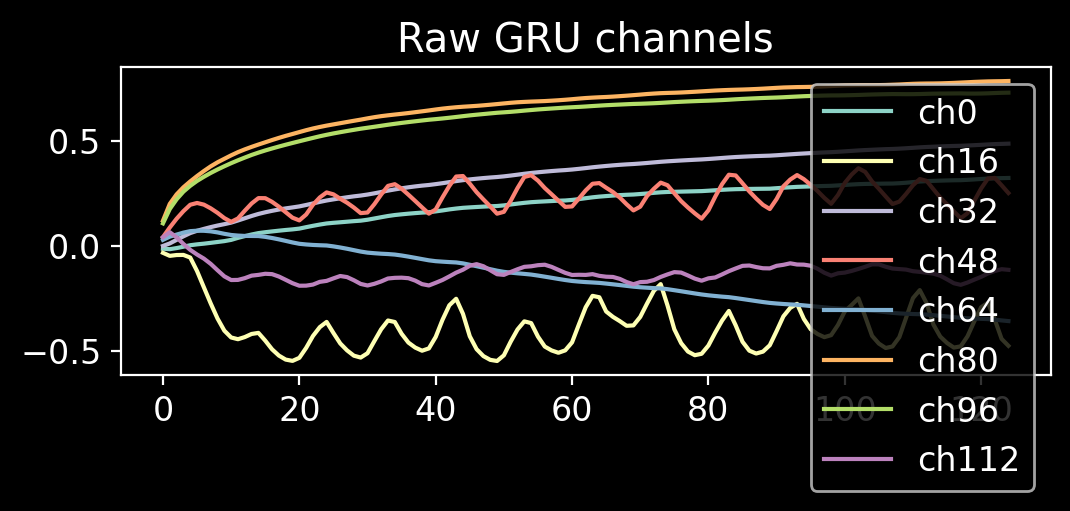

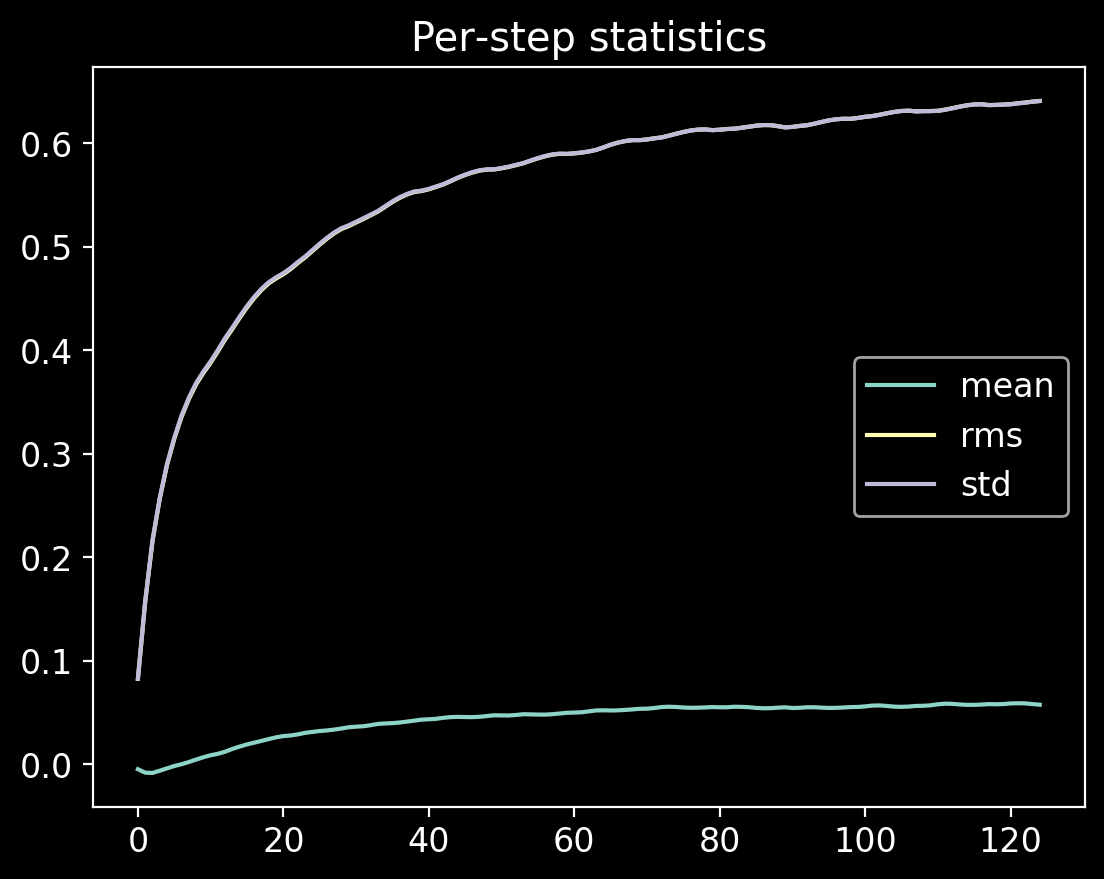

In [60]:
seq = activation_trace["gru"][0]           # (T=250, H=128) on CPU
print("shape:", seq.shape)

# (1) plot a handful of raw channels
plt.figure(figsize=(6,2))
for ch in range(0, 128, 16):
    plt.plot(seq[:, ch], label=f"ch{ch}")
plt.legend(); plt.title("Raw GRU channels"); plt.show()

# (2) signed mean, std and L2‑norm per step
signed = seq.mean(-1)
l2     = seq.pow(2).mean(-1).sqrt()
std    = seq.std(-1)

plt.plot(signed, label="mean")
plt.plot(l2,     label="rms")
plt.plot(std,    label="std")
plt.legend(); plt.title("Per‑step statistics"); plt.show()


Saliency

In [68]:
time_window = (0, 1000)
sample = 0
lead_indices = [0, 1, 2, 3, 4, 5]  # define the leads you want to visualize

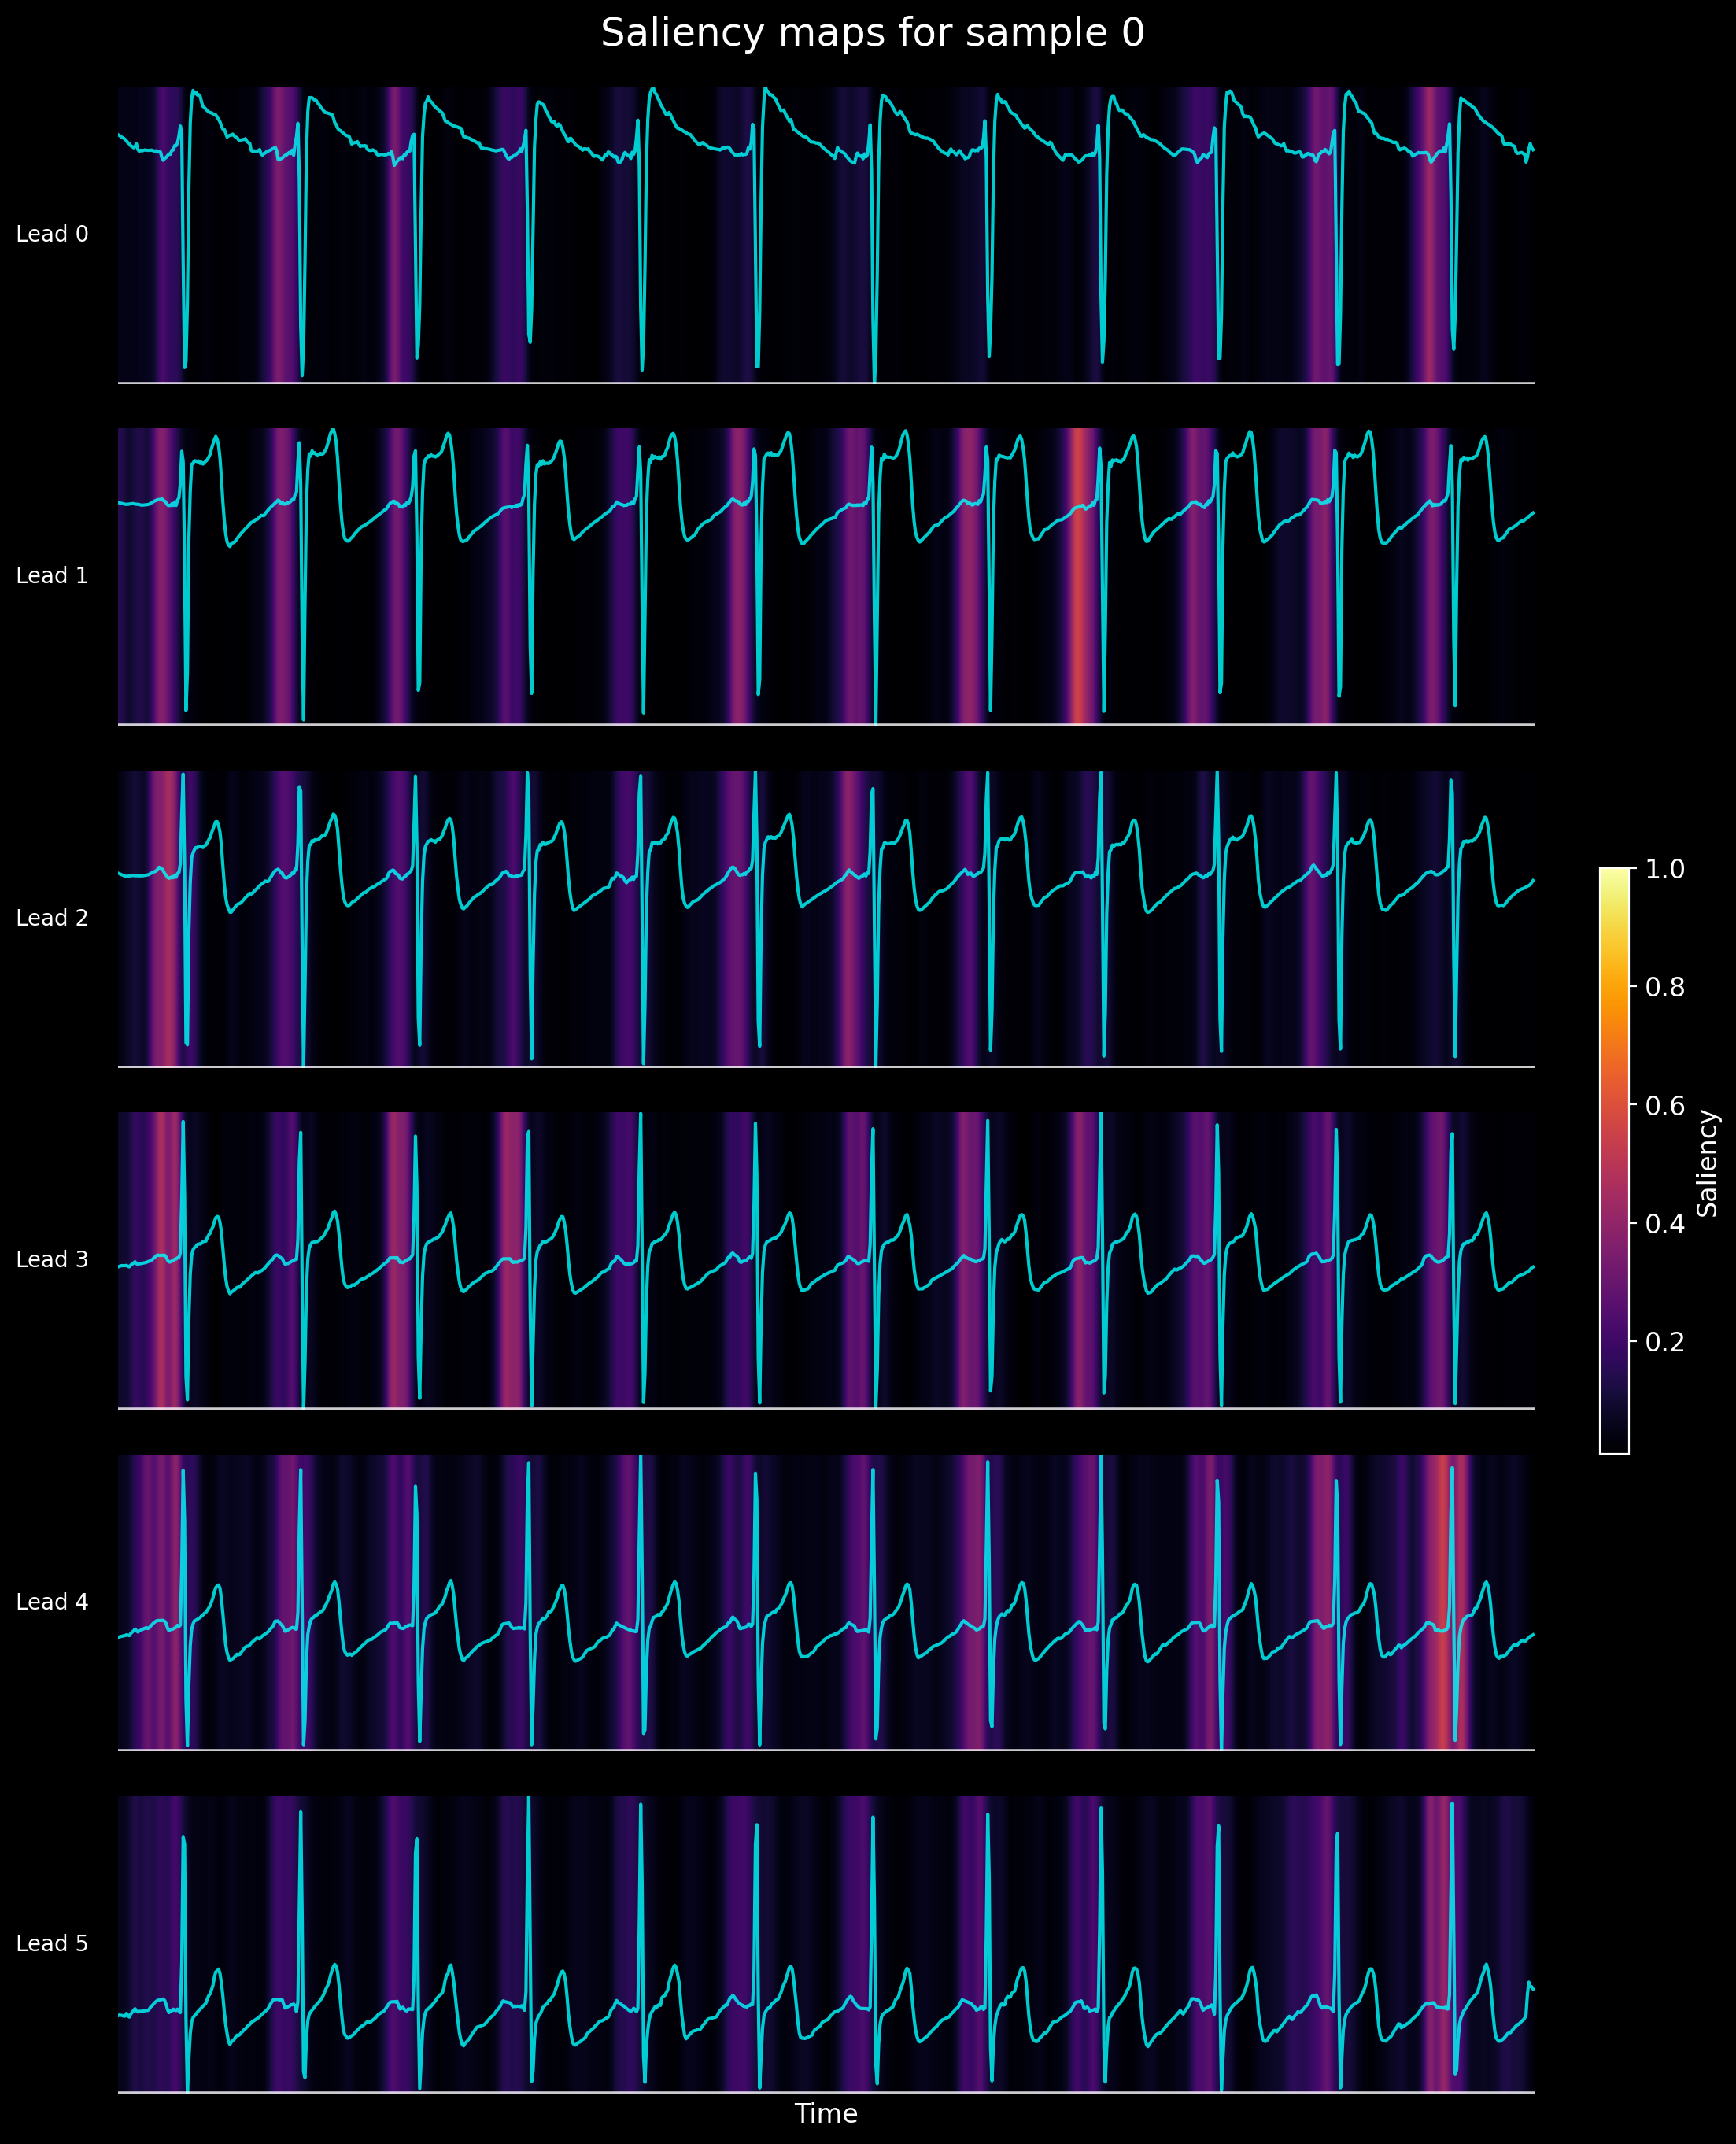

In [70]:
x = val_data[sample].unsqueeze(0).to(device)  # shape [1, L, T]
x.requires_grad = True

model.train()  # Put into train mode to get gradients
output = model(x)[0][0]  # [num_leads, num_classes]

num_leads = len(lead_indices)
fig, axes = plt.subplots(num_leads, 1, figsize=(12, 2.5 * num_leads), sharex=True,
                         gridspec_kw={'hspace': 0.15})

for i, lead in enumerate(lead_indices):
    lead_output = output[lead]
    target_idx = lead_output.argmax()
    target = lead_output[target_idx]

    model.zero_grad()
    x.grad = None
    target.backward(retain_graph=True)

    saliency = x.grad.data.abs()[0, lead].cpu().numpy()
    saliency = saliency / saliency.max()
    saliency = saliency[time_window[0]:time_window[1]]
    saliency_smooth = gaussian_filter1d(saliency, sigma=3)
    saliency_2d = saliency_smooth[np.newaxis, :]

    ecg = x[0, lead].cpu().detach().numpy()
    ecg = ecg[time_window[0]:time_window[1]]
    ecg_scaled = (ecg - ecg.min()) / (ecg.max() - ecg.min())

    ax = axes[i] if num_leads > 1 else axes
    im = ax.imshow(saliency_2d,
                   cmap='inferno',
                   aspect='auto',
                   extent=[0, len(ecg), 0, 1],
                   norm=plt.Normalize(vmin=0.01, vmax=saliency.max()))

    ax.plot(np.arange(len(ecg)), ecg_scaled, color='cyan', linewidth=1.5, linestyle='-', alpha=0.8)

    # Minimal labeling
    ax.set_yticks([])
    ax.set_ylabel(f"Lead {lead}", color='white', rotation=0, labelpad=30, fontsize=10, va='center')
    ax.set_facecolor('black')
    ax.tick_params(colors='white')
    ax.axhline(y=0, color='white', linewidth=2, alpha=0.8)

    # Clean borders
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Hide x-ticks on all but last subplot
    if i < num_leads - 1:
        ax.set_xticks([])
    else:
        ax.set_xlabel('Time', color='white')

# Add a single colorbar to the side
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label('Saliency', color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(cbar.ax.get_yticklabels(), color='white')

# Title for the whole figure
fig.suptitle(f'Saliency maps for sample {sample}', color='white', fontsize=18)
fig.patch.set_facecolor('black')

#plt.tight_layout(rect=[0, 0, 0.97, 0.90])
plt.subplots_adjust(left=0.1, right=0.85, top=0.95, bottom=0.1)
plt.show()